In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile

In [2]:
# Pandas precision
pd.set_option('display.precision', 9)
# 629145480 number of rows

In [14]:
n = 150_000
freq = 500
columns = [
    'mean', 'std', 'min', 'max', 'sum', 'abs_mean', 'abs_std', 'abs_max', 'abs_sum', 'argmax', 'rate_mean', 'rate_std',
    'rate_max', 'rate_min', 'rate_abs_max'
]
# columns.extend(['fftr' + str(i) for i in range(0, 1000)])
# columns.extend(['fftr' + str(i) for i in range(n//2 - 1000, n//2)])
# columns.extend(['ffti' + str(i) for i in range(0, 1000)])
# columns.extend(['ffti' + str(i) for i in range(n//2 - 1000, n//2)])
# columns.extend(['fftr' + str(i) for i in range(n//2, n//2 + 1000)])
# columns.extend(['fftr' + str(i) for i in range(n - 1000, n)])
# columns.extend(['ffti' + str(i) for i in range(n//2, n//2 + 1000)])
# columns.extend(['ffti' + str(i) for i in range(n - 1000, n)])
columns.extend(['fftr' + str(i) for i in range(0, freq)])
columns.extend(['fftr' + str(i) for i in range(n//2 - freq, n//2 + freq)])
columns.extend(['fftr' + str(i) for i in range(n-freq, n)])
columns.extend(['ffti' + str(i) for i in range(0, freq)])
columns.extend(['ffti' + str(i) for i in range(n//2 - freq, n//2 + freq)])
columns.extend(['ffti' + str(i) for i in range(n-freq, n)])

roll_windows = [100, 500, 1000, 2000, 4000, 10000]
columns.extend(['rolling_mean_' + str(i) for i in roll_windows])
columns.extend(['rolling_std_' + str(i) for i in roll_windows])

df_train = pd.DataFrame(dtype=np.float, columns=columns)

In [15]:
def generate_features(chunk):
    mean = chunk['acoustic_data'].mean()
    std = chunk['acoustic_data'].std()
    min = chunk['acoustic_data'].min()
    max = chunk['acoustic_data'].max()
    sum = chunk['acoustic_data'].sum()
    abs_sum = chunk['acoustic_data'].abs().sum()
    abs_max = chunk['acoustic_data'].abs().max()
    abs_mean = chunk['acoustic_data'].abs().mean()
    abs_std = chunk['acoustic_data'].abs().std()
    argmax = chunk['acoustic_data'].abs().values.argmax()
    rate = np.diff(chunk['acoustic_data'].values)
    rate_mean = rate.mean()
    rate_std = rate.std()
    rate_max = rate.max()
    rate_min = rate.min()
    rate_abs_max = np.abs(rate).max()
    fft = np.fft.fft(chunk['acoustic_data'], n=n)
    result = [
        mean, std, min, max, sum, abs_mean, abs_std, abs_max, abs_sum, argmax, rate_mean, rate_std, rate_max, rate_min,
        rate_abs_max
    ]
#     result.extend(list(fft.real[0:1000]))
#     result.extend(list(fft.real[n//2-1000:n//2]))
#     result.extend(list(fft.imag[0:1000]))
#     result.extend(list(fft.imag[n//2-1000:n//2]))
#     result.extend(list(fft.real[n//2:n//2+1000]))
#     result.extend(list(fft.real[n-1000:n]))
#     result.extend(list(fft.imag[n//2:n//2+1000]))
#     result.extend(list(fft.imag[n-1000:n]))
    result.extend(list(fft.real[0:freq]))
    result.extend(list(fft.real[n//2-freq:n//2+freq]))
    result.extend(list(fft.real[n-freq:n]))
    result.extend(list(fft.imag[0:freq]))
    result.extend(list(fft.imag[n//2-freq:n//2+freq]))
    result.extend(list(fft.imag[n-freq:n]))
    for window in roll_windows:
        result.append(
            chunk['acoustic_data'].rolling(window=window).mean().mean(skipna=True)
        )
        result.append(
            chunk['acoustic_data'].rolling(window=window).std().mean(skipna=True)
        )
    return result

In [16]:
i = 0
for chunk in pd.read_csv('data/train.csv', chunksize=n):
    df_train.loc[i, columns] = generate_features(chunk)
    df_train.loc[i, 'time_to_failure'] = chunk['time_to_failure'].values[-1]
    i += 1

In [17]:
df_train.head()

,mean,std,min,max,sum,abs_mean,abs_std,abs_max,abs_sum,argmax,...,rolling_mean_2000,rolling_mean_4000,rolling_mean_10000,rolling_std_100,rolling_std_500,rolling_std_1000,rolling_std_2000,rolling_std_4000,rolling_std_10000,time_to_failure
0,4.884113333,5.101106131,-98.0,104.0,732617.0,5.576566667,4.333324674,104.0,836485.0,2592.0,...,4.182269694,4.883418266,4.288590311,4.881665249,4.411259502,4.879250551,4.460670633,4.876886100,4.431413244,1.430797186
1,4.725766667,6.588823782,-154.0,181.0,708865.0,5.734166667,5.732776966,181.0,860125.0,11860.0,...,4.653421355,4.724876383,4.843485536,4.724689860,5.116232929,4.721938879,5.476469293,4.713898269,6.046480431,1.391498893
2,4.906393333,6.967397034,-106.0,140.0,735959.0,6.152646667,5.895944714,140.0,922897.0,129279.0,...,5.178792262,4.905839578,5.423012904,4.906173495,5.774157759,4.904014151,6.125550607,4.901086207,6.324556488,1.353196095
3,4.902240000,6.922305187,-199.0,197.0,735336.0,5.933960000,6.061213600,199.0,890094.0,67060.0,...,4.743548231,4.901486292,4.939280458,4.901312417,5.226714645,4.899401829,5.569334638,4.890118824,6.102269867,1.313797802
4,4.908720000,7.301110190,-126.0,145.0,736308.0,6.110586667,6.329485314,145.0,916588.0,80896.0,...,4.950485374,4.910195703,5.121868457,4.910102418,5.377340466,4.909516745,5.770087321,4.912307696,6.314026153,1.274399509


In [19]:
X_train = df_train.drop(columns=['time_to_failure']).values
y_train = df_train['time_to_failure'].values

In [41]:
rfr = RandomForestRegressor(n_estimators=500, random_state=0, n_jobs=-1)
pipe_rfr = Pipeline([('StandardScaler', StandardScaler()), ('RandomForestRegressor', rfr)])

In [42]:
pipe_rfr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [75]:
features = pd.DataFrame({'Feature': columns, 'Importance': rfr.feature_importances_, 'Correlation': df_train.drop(columns='time_to_failure').corrwith(df_train['time_to_failure']).abs().values})

In [77]:
# features = features.sort_values(by='Correlation', ascending=False)
features = features.sort_values(by='Importance', ascending=False)
features

,Feature,Importance,Correlation
4022,rolling_std_500,0.000700042,0.363046396
4020,rolling_mean_10000,0.002197235,0.358516850
4024,rolling_std_2000,0.000801696,0.356685719
4018,rolling_mean_2000,0.016739319,0.351513349
4016,rolling_mean_500,0.409480064,0.342833017
4026,rolling_std_10000,0.001448876,0.326174597
8,abs_sum,0.000705820,0.287142550
5,abs_mean,0.000786540,0.286797748
1,std,0.001387942,0.217134746
6,abs_std,0.003146086,0.201231156


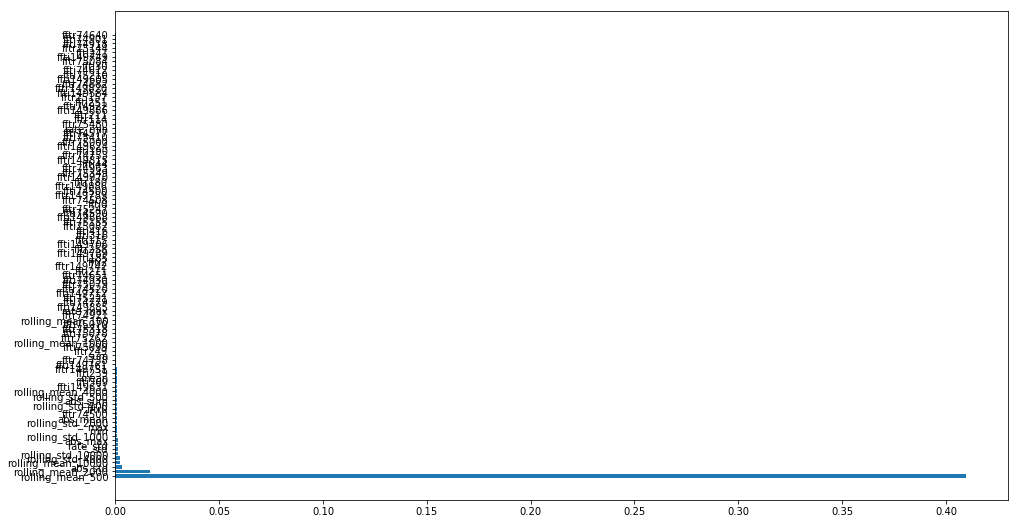

In [44]:
plt.figure(figsize=(16, 9))
plt.barh(y='Feature', width='Importance', data=features[:100])
plt.show()

In [52]:
X_train = df_train[features['Feature'][:27]].values
y_train = df_train['time_to_failure'].values

In [53]:
pipe = Pipeline([('StandardScaler', StandardScaler()), ('Regressor', MLPRegressor(random_state=0))])

In [55]:
param_grid = [{
    'Regressor__hidden_layer_sizes': [(18), (18, 12), (18, 12, 8)],
    'Regressor__alpha': [0.0001, 0.001, 0.01, 0.1],
    'Regressor__learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'Regressor__tol': [0.0001, 0.001, 0.01]
}]

In [56]:
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    iid=False,
    n_jobs=-1,
    cv = KFold(
        n_splits=10,
        shuffle=True,
        random_state=0
    )
)

gs.fit(X_train, y_train)
print('Best score:', gs.best_score_)
print('Best hyperparameters:', gs.best_params_)

Best score: 0.4384087789719068
Best hyperparameters: {'Regressor__alpha': 0.01, 'Regressor__hidden_layer_sizes': 18, 'Regressor__learning_rate_init': 0.1, 'Regressor__tol': 0.01}


In [60]:
path = 'data/test/'
files = [f[:-4] for f in listdir(path) if isfile(path + f)]

In [61]:
predictions = pd.DataFrame(index=files, dtype=np.float, columns=['time_to_failure'])
predictions.index.name = 'seg_id'

In [62]:
for f in files:
    df = pd.read_csv(path+f+'.csv')
    df_test = pd.DataFrame(np.array(generate_features(df)).reshape(1,-1), columns=columns)
    X_test = df_test[features['Feature'][:27]].values
    y = gs.predict(X_test)[0]
    predictions.loc[f, 'time_to_failure'] = y

In [63]:
predictions.to_csv('submission.csv')

In [64]:
predictions

,time_to_failure
seg_id,
seg_5fe414,2.695770116
seg_3661de,9.861931215
seg_5ef47e,5.391954501
seg_58e9f9,8.253845824
seg_afd665,4.431446236
seg_e54932,7.527261793
seg_3a1600,2.621848790
seg_bca500,4.149011556
seg_4ca6de,6.624427784
